# Kaggle Sartorius - Cell Instance Segmentatoin
현미경 이미지에서 단일 신경세포 감지  
https://www.kaggle.com/code/julian3833/sartorius-starter-torch-mask-r-cnn-lb-0-273

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import random
import collections

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

## 변수설정

In [2]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
fix_all_seeds(2021)

In [3]:
TRAIN_CSV = '../data/paper_review/maskrcnn_cell/train.csv'
TRAIN_PATH = '../data/paper_review/maskrcnn_cell/train'
TEST_PATH = '../data/paper_review/maskrcnn_cell/test'

WIDTH = 704
HEIGHT = 520

TEST = False    # Test를 하는 경우에는 Train csv를 5000줄만 가져오게 할 예정
NORMALIZE = False
USE_SCHEDULER = False

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

resnet_mean = (0.485, 0.456, 0.406)
resnet_std = (0.229, 0.224, 0.225)

n_epochs = 10
batch_size = 2
momentum = 0.9
lr = 0.001
weight_decay = 0.0005

# mask rcnn 에서는 0.5를 기준으로 mask가 있는지 없는지 판단
mask_threshold = 0.5

box_detections_per_img = 539
min_score = 0.45

## Train Dataset

In [4]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [5]:
# 이미지 플립
class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob
        
    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target['boxes']
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target['boxes'] = bbox
            target['masks'] = target['masks'].flip(-2)
        return image, target
    
class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob
        
    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target['boxes']
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target['boxes'] = bbox
            target['masks'] = target['masks'].flip(-1)
        return image, target

In [6]:
# 데이터 처리
class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target
    
class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    
def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())
    
    # Data augmentation for train
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

In [7]:
# 마스크 표기하는 함수
# shape: (height, width)
# return 0:background, 1:mask

def rle_decode(annotation, shape, color=1):
    s = annotation.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

## Train Dataset & DataLoader

In [8]:
class CellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        self.should_resize = resize is not False
        
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
        else:
            self.height = HEIGHT
            self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
        
        for index, row in temp_df.iterrows():
            self.image_info[index] = {'image_id': row['id'], 
                                      'image_path': os.path.join(self.image_dir, row['id']+'.png'),
                                      'annotations': row['annotation']}
            
    def get_box(self, a_mask):
        # 주어진 mask로부터 bbox 확보
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        img_path = self.image_info[idx]['image_path']
        img = Image.open(img_path).convert('RGB')

        if self.should_resize:
            img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)

        # bbox 좌표 얻기
        boxes = []
        for i, annotation in enumerate(info['annotations']):
            a_mask = rle_decode(annotation, (HEIGHT, WIDTH))
            a_mask = Image.fromarray(a_mask)

            if self.should_resize:
                a_mask = a_mask.resize((self.width, self.height), resample=Image.BILINEAR)

            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask
            boxes.append(self.get_box(a_mask))

        # dummy lables
        labels = [1 for _ in range(n_objects)]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        target = {'boxes': boxes,
                  'labels': labels,
                  'masks': masks,
                  'image_id': image_id,
                  'area': area,
                  'iscrowd': iscrowd}

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [9]:
df_train = pd.read_csv(TRAIN_CSV, nrows=5000 if TEST else None)
ds_train = CellDataset(TRAIN_PATH, df_train, resize=False, transforms=get_transform(train=True))
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

## Model

In [10]:
def get_model():
    NUM_CLASSES = 2
    
    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=box_detections_per_img,
                                                                   image_mean=resnet_mean,
                                                                   image_std=resnet_std)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=box_detections_per_img)
    
    # pretrained 모델의 필요한 부분을 가져오고 새로운 학습을 위해서 해서 설정해야 하는 부분 설정해주기
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
    
    # get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # replace mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
    
    return model

In [11]:
model = get_model()
model.to(device)

for param in model.parameters():
    param.requires_grad = True
    
model.train()
# pretrained 모델의 구조에서 roi head에 있는 box predictor와 mask predictor의 output이 바뀐걸 확인할 수 있음

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Train

In [12]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
n_batches = len(dl_train)

In [13]:
for epoch in range(n_epochs):
    
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
        
        # predic
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
        
        # if batch_idx % 10 == 0:
        #     print(f'Batch {batch_idx:3d}/{n_batches:3d}  Batch Train Loss {loss.item():7.3f}  Mask Only Loss {loss_mask:7.3f}')
            
    if USE_SCHEDULER:
        lr_scheduler.step()
        
    train_loss = loss_accum/n_batches
    train_loss_mask = loss_mask_accum/n_batches
    
    take_time = time.time()-time_start
    
    # torch.save(model.state_dict(), f'model_{epoch}.bin')
    prefix = f'Epoch {epoch:2d}/{n_epochs:2d}'
    print(f'{prefix} -- Train Loss {train_loss:.3f} -- Train Mask Only Loss {train_loss_mask:.3f} -- Take time {take_time:.0f}sec')

Epoch  0/10 -- Train Loss 1.754 -- Train Mask Only Loss 0.367 -- Take time 103sec
Epoch  1/10 -- Train Loss 1.514 -- Train Mask Only Loss 0.320 -- Take time 103sec
Epoch  2/10 -- Train Loss 1.462 -- Train Mask Only Loss 0.315 -- Take time 103sec
Epoch  3/10 -- Train Loss 1.436 -- Train Mask Only Loss 0.312 -- Take time 102sec
Epoch  4/10 -- Train Loss 1.414 -- Train Mask Only Loss 0.309 -- Take time 101sec
Epoch  5/10 -- Train Loss 1.393 -- Train Mask Only Loss 0.308 -- Take time 101sec
Epoch  6/10 -- Train Loss 1.384 -- Train Mask Only Loss 0.307 -- Take time 102sec
Epoch  7/10 -- Train Loss 1.369 -- Train Mask Only Loss 0.305 -- Take time 102sec
Epoch  8/10 -- Train Loss 1.361 -- Train Mask Only Loss 0.304 -- Take time 103sec
Epoch  9/10 -- Train Loss 1.353 -- Train Mask Only Loss 0.304 -- Take time 103sec


In [14]:
def analyze_train_sample(model, ds_train, sample_index=10):
    
    # sample image
    img, targets = ds_train[sample_index]
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.title('Sample Image')
    plt.show()
    
    # ground truth
    masks = np.zeros((HEIGHT, WIDTH))
    for mask in targets['masks']:
        masks = np.logical_or(masks, mask)
        
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.imshow(masks, alpha=0.3)
    plt.title('Ground Truth')
    plt.show()
    
    # pred
    model.eval()
    with torch.no_grad():
        preds = model([img.to(device)])[0]
        
    plt.imshow(img.cpu().numpy().transpose((1, 2, 0)))
    all_preds_masks = np.zeros((HEIGHT, WIDTH))
    for mask in preds['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > mask_threshold)
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title('Predictions')
    plt.show
    
    return preds

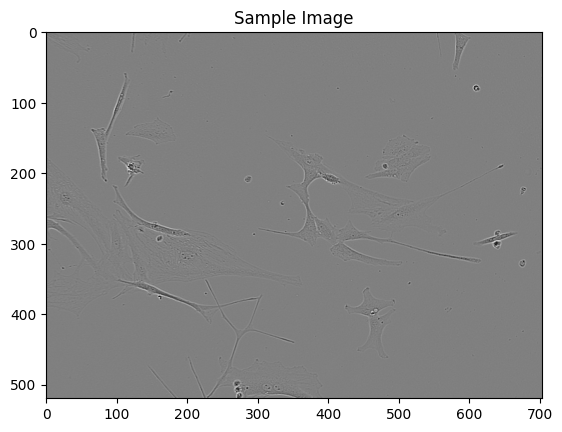

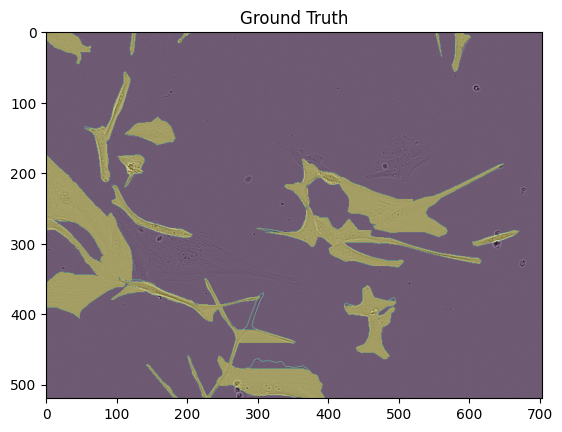

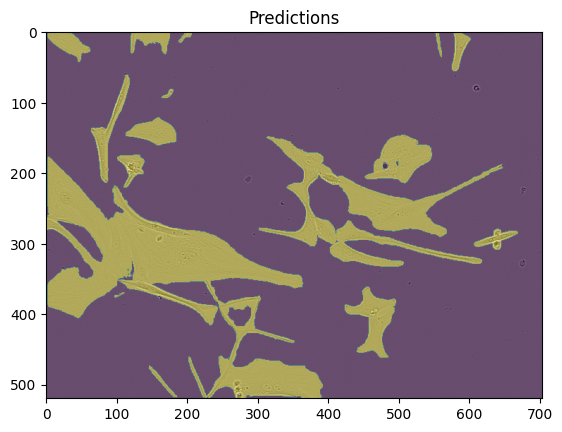

In [15]:
val_pred = analyze_train_sample(model, ds_train, 20)

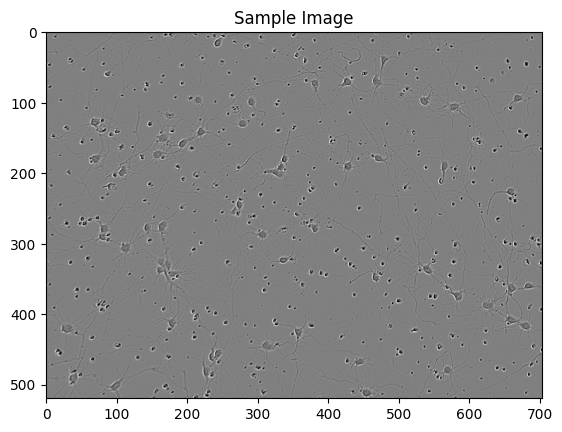

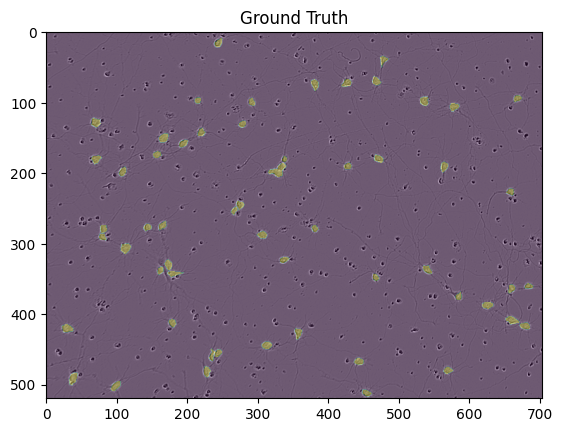

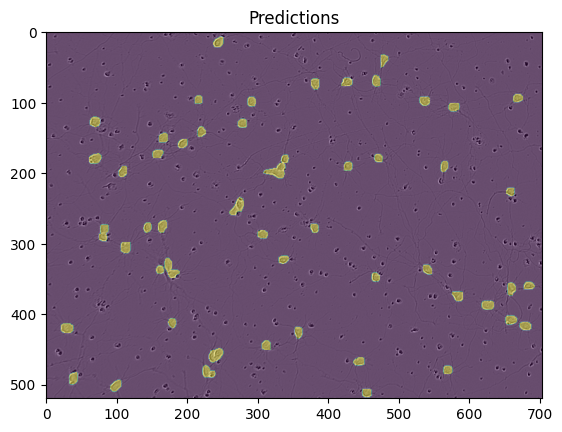

In [16]:
val_pred = analyze_train_sample(model, ds_train, 100)

## Test

In [17]:
class CellTestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir)]
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        image = Image.open(image_path).convert('RGB')
        
        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
        return {'image': image, 'image_id': image_id}
    
    def __len__(self):
        return len(self.image_ids)

In [18]:
ds_test = CellTestDataset(TEST_PATH, transforms=get_transform(train=False))
ds_test[0]

{'image': tensor([[[0.4902, 0.4980, 0.5137,  ..., 0.5647, 0.5765, 0.5059],
          [0.4784, 0.4824, 0.5020,  ..., 0.4314, 0.6039, 0.5608],
          [0.4902, 0.4588, 0.4784,  ..., 0.2745, 0.4784, 0.6000],
          ...,
          [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.5020, 0.5059],
          [0.5098, 0.5059, 0.4980,  ..., 0.5059, 0.5059, 0.5059],
          [0.5216, 0.5137, 0.5059,  ..., 0.5059, 0.5059, 0.5020]],
 
         [[0.4902, 0.4980, 0.5137,  ..., 0.5647, 0.5765, 0.5059],
          [0.4784, 0.4824, 0.5020,  ..., 0.4314, 0.6039, 0.5608],
          [0.4902, 0.4588, 0.4784,  ..., 0.2745, 0.4784, 0.6000],
          ...,
          [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.5020, 0.5059],
          [0.5098, 0.5059, 0.4980,  ..., 0.5059, 0.5059, 0.5059],
          [0.5216, 0.5137, 0.5059,  ..., 0.5059, 0.5059, 0.5020]],
 
         [[0.4902, 0.4980, 0.5137,  ..., 0.5647, 0.5765, 0.5059],
          [0.4784, 0.4824, 0.5020,  ..., 0.4314, 0.6039, 0.5608],
          [0.4902, 0.4588, 0.47

In [19]:
# get mask 
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    
    for b in dots:
        if (b > prev+1):
            run_lengths.extend((b+1, 0))
            run_lengths[-1] += 1
            prev = b
            
    return ' '.join(map(str, run_lengths))

# 겹치는 부분 지우기
def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
            
    return mask

In [20]:
model.eval()
submission = []

for sample in ds_test:
    img = sample['image']
    image_id = sample['image_id']
    with torch.no_grad():
        result = model([img.to(device)])[0]
        
    previous_masks = []
    for i, mask in enumerate(result['masks']):
        score = result['scores'][i].cpu().item()
        if score < min_score:
            continue
            
        # 가장 연관성 높은 mask만 남기기
        mask = mask.cpu().numpy()
        binary_mask = mask > mask_threshold
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        rle = rle_encoding(binary_mask)
        submission.append((image_id, rle))
        
    # 이미지에 대해서 rle가 생성되지 않으면 빈 prediction 추가
    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ''))

In [21]:
df_sub = pd.DataFrame(submission, columns=['id', 'pred'])
df_sub.to_csv('../data/paper_review/maskrcnn_cell/submission.csv', index=False)
df_sub.head()

,id,pred
0,d8bfd1dafdc4,70392 1 71095 1 71097 1 71799 1 71801 1 71803 ...
1,d8bfd1dafdc4,823 1 825 1 827 1 829 1 1526 1 1528 1 1530 1 1...
2,d8bfd1dafdc4,173409 1 174111 1 174113 1 174815 1 174817 1 1...
3,d8bfd1dafdc4,162545 1 163247 1 163249 1 163251 1 163950 1 1...
4,d8bfd1dafdc4,266460 1 266462 1 267154 1 267163 1 267165 1 2...


## 시각화 

In [22]:
min_score = 0.43
def visualized_test(ds_test, sample_index):
    
    # test sample
    img = ds_test[sample_index]['image']
    image_id = ds_test[sample_index]['image_id']
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.title('Test Sample Image')
    plt.show()
    
    # test predict
    model.eval()
    with torch.no_grad():
        result = model([img.to(device)])[0]
        
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    all_preds_masks = np.zeros((HEIGHT, WIDTH))
    
    previous_masks = []
    for i, mask in enumerate(result['masks']):
        score = result['scores'][i].cpu().item()
        if score < min_score:
            continue
            
        # 가장 연관성 높은 mask만 남기기
        mask = mask.cpu().numpy()
        binary_mask = mask > mask_threshold
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        
        for mask in previous_masks:
            all_preds_masks = np.logical_or(all_preds_masks, mask[0] > mask_threshold)
        
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title('Test Pred')
    plt.show()

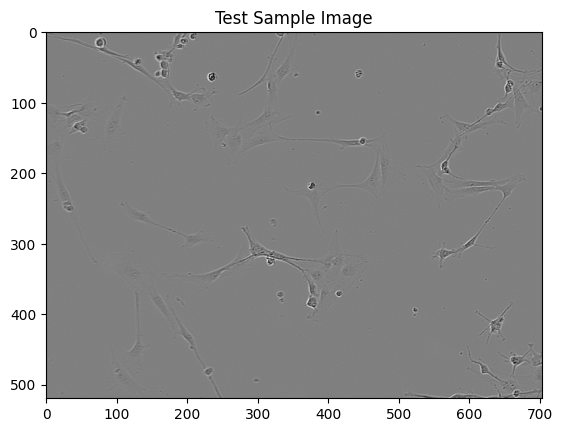

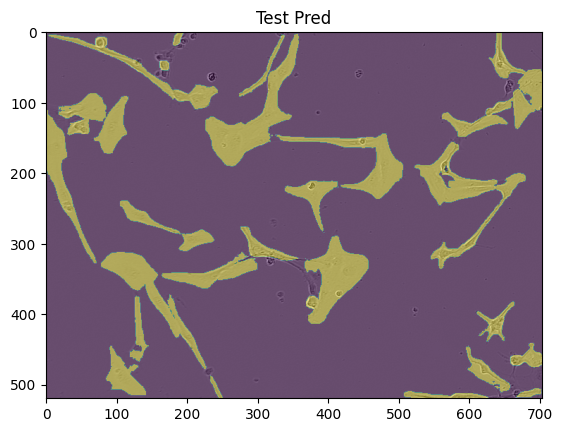

In [23]:
visualized_test(ds_test, 1)

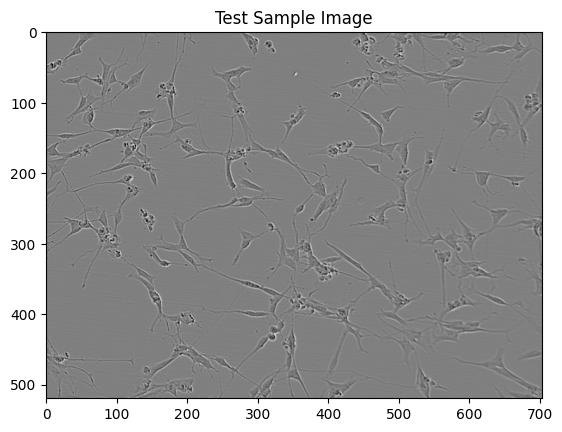

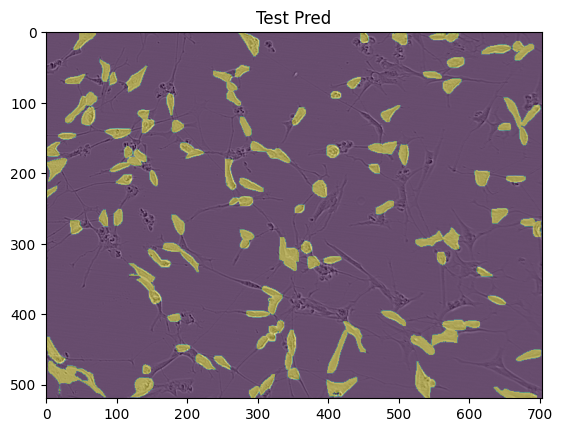

In [24]:
visualized_test(ds_test, 2)

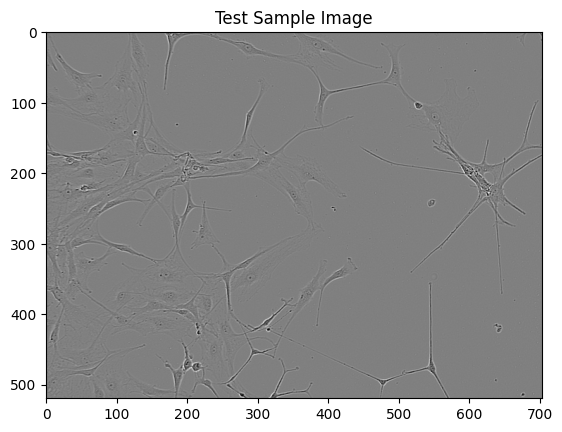

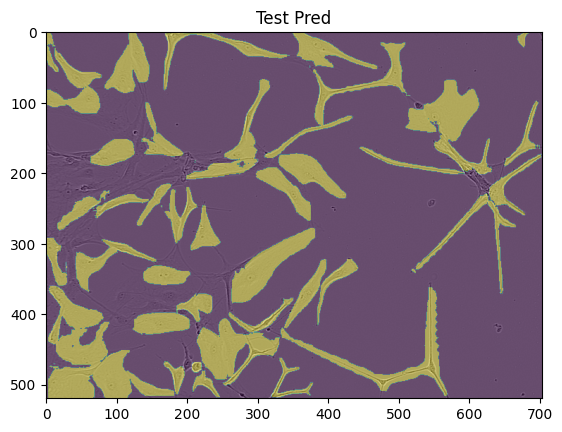

In [26]:
visualized_test(ds_test, 0)